# Insurance Claims Prediction - Regression
This solution provides an end-to-end approach to predicting insurance claims, encompassing feature engineering, model training, and inference. It demonstrates seamless integration between Snowflake’s Feature Store and Model Registry for streamlined ML operations.
Key steps in this solution include:

- Demonstrating the use of Snowflake Feature Store for feature management.
- Accessing and analyzing insurance claims data using the DataFrame API.
- Creating new calculated fields with the DataFrame API and vectorized UDFs.
- Applying essential transformations (e.g., Ordinal encoding) using the Snowpark ML Preprocessing API.
- Building a preprocessing pipeline with the Snowpark ML Modeling API.
- Training an XGBoost model on the insurance claims dataset via the Snowpark ML Model API.
- Optimizing model parameters using Snowpark ML's Distributed GridSearchCV() function.
- Deploying predictions through Snowflake Model Registry.

Note: All feature transformations and hyperparameter tuning in this solution leverage distributed operations, consistent with Snowpark DataFrame processes.


Import the necessary packages for development.

In [1]:
# Import the necessary libraries
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Snowpark for Python
from snowflake.snowpark.context import get_active_session
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.dataframe import col, DataFrame
from snowflake.snowpark.functions import udf, sum, lit, log, when,   upper,regexp_replace,min, max, round
from snowflake.snowpark.types import DecimalType, IntegerType, StringType, StructType, FloatType, StructField, DateType, Variant, VariantType, PandasSeriesType, DoubleType

from snowflake.snowpark import Window as window

# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation

#Feature Store
from snowflake.ml.feature_store import (
    FeatureStore,
    FeatureView,
    Entity,
    CreationMode
)

#ML modeling
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml._internal.utils import identifier
from snowflake.ml.registry import Registry
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error

# warning suppresion
import warnings; warnings.simplefilter('ignore')

# Misc
import sys
from os import environ
import json
import joblib
import cachetools
import snowflake.snowpark.functions as F

session = get_active_session()

# Add a query tag to the session. This helps with debugging and performance monitoring.
session.query_tag = {"origin":"sf_sit", "name":"insurance_claims_prediction_regression", "version":{"major":1, "minor":0}, "attributes":{"is_quickstart":0, "source":"notebook"}}

db = str(session.get_current_database().strip('"'))
solution_prefix = (db.upper()).split('_PROD')[0]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Feature Store Creation
The Snowflake Feature Store is designed to make creating, storing, and managing features for data science and machine learning workloads easier and more efficient. Producers manage feature views and entities in the feature store, facilitating collaboration and feature reuse across departments. This approach breaks down silos between training and serving environments and simplifies aggregations and moving window calculations using Python commands.

### Feature Store Schema & Privileges
Create a feature store schema and grant all necessary privileges for the producer to create feature store views, as well as the privileges for consumers to access these views.

In [ ]:
 -- $FS_ROLE_PRODUCER create feature views and $FS_ROLE_CONSUMER uses the feature views for training. These roles are created as part of the setup
USE ROLE ACCOUNTADMIN;
SET FS_ROLE_PRODUCER = '{{solution_prefix}}_FS_PRODUCER';
SET FS_ROLE_CONSUMER = '{{solution_prefix}}_DATA_SCIENTIST';
SET FS_DATABASE = '{{solution_prefix}}_PROD';
SET FS_SCHEMA = 'FS';
SET SCHEMA_FQN = CONCAT($FS_DATABASE, '.', $FS_SCHEMA);
SET FS_WAREHOUSE = '{{solution_prefix}}_DS_WH';
SET MR_DEMO_DB='{{solution_prefix}}_PROD';

-- Create schema
CREATE SCHEMA IF NOT EXISTS IDENTIFIER($FS_SCHEMA);

-- Build role hierarchy
GRANT ROLE IDENTIFIER($FS_ROLE_CONSUMER) TO ROLE IDENTIFIER($FS_ROLE_PRODUCER);

-- Grant PRODUCER role privileges
GRANT USAGE ON DATABASE IDENTIFIER($FS_DATABASE) TO ROLE IDENTIFIER($FS_ROLE_PRODUCER);
GRANT USAGE ON SCHEMA IDENTIFIER($SCHEMA_FQN) TO ROLE IDENTIFIER($FS_ROLE_PRODUCER);
GRANT CREATE DYNAMIC TABLE ON SCHEMA IDENTIFIER($SCHEMA_FQN) TO ROLE IDENTIFIER($FS_ROLE_PRODUCER);
GRANT CREATE VIEW ON SCHEMA IDENTIFIER($SCHEMA_FQN) TO ROLE IDENTIFIER($FS_ROLE_PRODUCER);
GRANT CREATE TAG ON SCHEMA IDENTIFIER($SCHEMA_FQN) TO ROLE IDENTIFIER($FS_ROLE_PRODUCER);
GRANT CREATE DATASET ON SCHEMA IDENTIFIER($SCHEMA_FQN) TO ROLE IDENTIFIER($FS_ROLE_PRODUCER);
GRANT APPLY TAG ON ACCOUNT TO ROLE IDENTIFIER($FS_ROLE_PRODUCER);

-- Grant CONSUMER role privileges
GRANT USAGE ON DATABASE IDENTIFIER($FS_DATABASE) TO ROLE IDENTIFIER($FS_ROLE_CONSUMER);
GRANT USAGE ON SCHEMA IDENTIFIER($SCHEMA_FQN) TO ROLE IDENTIFIER($FS_ROLE_CONSUMER);
GRANT SELECT,MONITOR ON FUTURE DYNAMIC TABLES IN SCHEMA IDENTIFIER($SCHEMA_FQN) TO ROLE IDENTIFIER($FS_ROLE_CONSUMER);
GRANT SELECT,MONITOR ON ALL DYNAMIC TABLES IN SCHEMA IDENTIFIER($SCHEMA_FQN) TO ROLE IDENTIFIER($FS_ROLE_CONSUMER);
GRANT SELECT,REFERENCES ON FUTURE VIEWS IN SCHEMA IDENTIFIER($SCHEMA_FQN) TO ROLE IDENTIFIER($FS_ROLE_CONSUMER);
GRANT SELECT,REFERENCES ON ALL VIEWS IN SCHEMA IDENTIFIER($SCHEMA_FQN) TO ROLE IDENTIFIER($FS_ROLE_CONSUMER);
GRANT CREATE DATASET ON SCHEMA IDENTIFIER($SCHEMA_FQN) TO ROLE IDENTIFIER($FS_ROLE_CONSUMER);

-- [Optional] Grant USAGE ON WAREHOUSE to CONSUMER
GRANT USAGE ON WAREHOUSE IDENTIFIER($FS_WAREHOUSE) TO ROLE IDENTIFIER($FS_ROLE_CONSUMER);
GRANT USAGE ON SCHEMA IDENTIFIER($SCHEMA_FQN) TO ROLE IDENTIFIER($FS_ROLE_PRODUCER);

### Create a new FeatureStore client

Let's first create a feature store client. With `CREATE_IF_NOT_EXIST` mode, it will try to create schema and all necessary feature store metadata if it doesn't exist already. It is required for the first time to setup a Feature Store. Afterwards, you can use `FAIL_IF_NOT_EXIST` mode to connecte to an existing Feature Store.

In [ ]:
session.sql(f'USE ROLE {solution_prefix}_FS_PRODUCER')
session.sql(f'USE WAREHOUSE {solution_prefix}_DS_WH').collect()
session.sql('USE SCHEMA FS').collect()

fs = FeatureStore(
    session=session, 
    database=f"{solution_prefix}_PROD", 
    name="FS", 
    default_warehouse=f"{solution_prefix}_DS_WH",
    creation_mode=CreationMode.CREATE_IF_NOT_EXIST,
)

In [ ]:
# Specify the table name where we stored the Insurance claims dataset
insurance_policy_claims_df = session.table("raw.motor_insurance_policy_claims")

# Display the DataFrame
insurance_policy_claims_df.show(5)

### Grouping and transforming the features

Grouping input variables is common, but it reduces data granularity, potentially diminishing the model's predictive power due to less available information. Yet, in cases of low-volume-high-variability segments, grouping can enhance stability. Striking a balance between granularity and stability is crucial. Grouping features before one-hot encoding can also reduce the size of the encoded dataset.

In [ ]:
insurance_policy_claims_df=insurance_policy_claims_df.with_column("Driver_Age_Banded",\
        when(col("DRIVAGE") < 18, lit("DRIVAGE_Under_18")) \
        .when(col("DRIVAGE") <= 21, lit("DRIVAGE_18-21")) \
        .when(col("DRIVAGE") <= 25, lit("DRIVAGE_21-25")) \
        .when(col("DRIVAGE") <= 35, lit("DRIVAGE_25-35")) \
        .when(col("DRIVAGE") <= 45, lit("DRIVAGE_35-45")) \
        .when(col("DRIVAGE") <= 55, lit("DRIVAGE_45-55")) \
        .when(col("DRIVAGE") <= 70, lit("DRIVAGE_55-70")) \
        .otherwise(lit("DRIVAGE_Over_70,")))

insurance_policy_claims_df=insurance_policy_claims_df.with_column("Vehicle_Age_Banded",\
        when(col("VEHAGE") <= 0, lit("VEHAGE_NewVehicle")) \
        .when(col("VEHAGE") <= 1, lit("VEHAGE_0-1")) \
        .when(col("VEHAGE") <= 4, lit("VEHAGE_1-4")) \
        .when(col("VEHAGE") <= 10, lit("VEHAGE_4-10")) \
        .otherwise(lit("VEHAGE_Over_10,")))

insurance_policy_claims_df=insurance_policy_claims_df.withColumn("FS_LOG_DENSITY", log(2.718281828459045, insurance_policy_claims_df["DENSITY"]))
insurance_policy_claims_df=insurance_policy_claims_df.drop("DENSITY")
insurance_policy_claims_df.show()

### Create and register a new Entity

We will create an Entity called *INSURANCECLAIMS* and register it with the feature store.

You can retrieve the active Entities in the feature store with list_entities() API.

In [ ]:
claims_entity = Entity(name="INSURANCECLAIMS", join_keys=["IDPOL"])
fs.register_entity(claims_entity)
fs.list_entities().show(1)

### Create a new FeatureView and materialize the feature pipeline

Now we construct a Feature View with above DataFrame. We firstly create a draft feature view. We set the `refresh_freq` to 1 minute, so it will be refreshed every 1 minute. On the backend, it creates a Snowflake [dynamic table](https://docs.snowflake.com/en/user-guide/dynamic-tables-intro). At this point, the draft feature view will not take effect because it is not registered yet.
Then we register the feature view by via `register_feature_view`. It will materialize to Snowflake backend. [Incremental maintenance](https://docs.snowflake.com/en/user-guide/dynamic-tables-refresh#label-dynamic-tables-intro-refresh-queries) will start if the query is supported.

In [ ]:
claims_fv = FeatureView(
    name="INSURANCE_CLAIMS_FEATURES", 
    entities=[claims_entity], 
    feature_df=insurance_policy_claims_df, 
    refresh_freq="1 minute", 
    desc="my insurance claims features auto refreshed on a schedule"
)
claims_features = fs.register_feature_view(
    feature_view=claims_fv, 
    version="V1", 
    block=True,
    overwrite=True
)
fs.read_feature_view(claims_features).show()

## Data Analysis 
`claim_nb` is the number of claims during the exposure period (i.e. policy lifetime).

`exposure` is the time that a policy is exposed to risk, expressed in years.

`area` is a density value of the city community where the car driver lives in. It ranges from “A” for rural area to “F” for urban centre.

`region` is French policy region.

`density` is a population density estimate — the number of inhabitants per km of the city where the policyholder lives.

`driv_age` is the age of the driver (in years).

`bonus_malus` The bonus-malus rating is a system in France where values below 100 are considered a bonus, and values above 100 are considered a malus. This Latin term, translating to "good bad," serves as a mechanism rewarding policyholders for positive claims behavior and penalizing them for negative claims behavior. Simply put, having fewer insurance claims results in reduced insurance costs. In the UK, a similar concept is known as a "no claims discount.

`veh_power` is the power of the car.

`veh_age` is the age of vehicle, in years.

`veh_brand` is the vehicle brand, grouped into various subgroups.

`veh_gas` is the vehicle fuel type. In this case, we have no electric or hybrid vehicles of any sort.


In [ ]:
USE ROLE {{solution_prefix}}_DATA_SCIENTIST;

### Compare DataFrame Size
Let's bring a sample of our Snowflake dataset to our Python environment in a pandas DataFrame using the to_pandas() function. We will compare how much memory is used for the pandas DataFrame compared to the Snowpark DataFrame. As we will see, no memory is used for the Snowpark DataFrame in our Python environment. All data in the Snowpark DataFrame remains on Snowflake.

**Value:** No copies or movement of data when working with Snowpark DataFrames.

In [6]:
insurance_policy_claims_pd_df=insurance_policy_claims_df.to_pandas()

# Get Snowpark DataFrame size
snowpark_df_size = sys.getsizeof(insurance_policy_claims_df) / (1024*1024)
print(f"Snowpark DataFrame Size (insurance_policy_claims_df): {snowpark_df_size:.2f} MB")

# Get pandas DataFrame size
pandas_df_size = sys.getsizeof(insurance_policy_claims_pd_df) / (1024*1024)
print(f"Pandas DataFrame Size (insurance_policy_claims_pd_df): {pandas_df_size:.2f} MB")

Snowpark DataFrame Size (insurance_policy_claims_df): 0.00 MB
Pandas DataFrame Size (insurance_policy_claims_pd_df): 211.39 MB


### Row Level Calculation
Reverse engineer the original `EXPOSURE` values based on a formula using scaled and min/max values.

Using Dataframe API and server side component - Vectroized UDF


In [7]:
# Scale Exposure using StandardScaler

input_columns_std_scaler=["EXPOSURE"]
output_columns_std_scaler = ["EXPOSURE_SCALED"]

snowml_stdscale = snowml.StandardScaler(input_cols=input_columns_std_scaler, output_cols=output_columns_std_scaler, with_mean='True')

stdscaler_transformed_claims_frequency_df = snowml_stdscale.fit(insurance_policy_claims_df).transform(insurance_policy_claims_df)

In [8]:
# Create proxy input columns for reverse engineering Exposure
stdscaler_transformed_claims_frequency_df=stdscaler_transformed_claims_frequency_df \
    .join(stdscaler_transformed_claims_frequency_df.groupBy().agg(min(col("EXPOSURE")).alias("Min_Original_Value")))\
    .join(stdscaler_transformed_claims_frequency_df.groupBy().agg(max(col("EXPOSURE")).alias("Max_Original_Value")))\
    .join(stdscaler_transformed_claims_frequency_df.groupBy().agg(min(col("EXPOSURE_SCALED")).alias("Min_Scaled_Value")))\
    .join(stdscaler_transformed_claims_frequency_df.groupBy().agg(max(col("EXPOSURE_SCALED")).alias("Max_Scaled_Value")))\
    .rename({col("EXPOSURE"):"ORIGINAL_EXPOSURE"})


#stdscaler_transformed_claims_frequency_df.show()
input_tbl_wo_exposure = "analytics.claims_wo_exposure"

stdscaler_transformed_claims_frequency_df.write.mode("overwrite").save_as_table(input_tbl_wo_exposure)
#Read the new table
insurance_policy_claims_wo_exposure_df = session.table(input_tbl_wo_exposure)

# Display the DataFrame
insurance_policy_claims_wo_exposure_df.show(5)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EXPOSURE_SCALED"    |"IDPOL"  |"CLAIMNB"  |"ORIGINAL_EXPOSURE"  |"AREA"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"VEHBRAND"  |"VEHGAS"   |"DENSITY"  |"REGION"  |"MIN_ORIGINAL_VALUE"  |"MAX_ORIGINAL_VALUE"  |"MIN_SCALED_VALUE"   |"MAX_SCALED_VALUE"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|-1.1764586839194764  |1        |1          |0.1                  |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |0.002732240437        |2.01   

Formula for reverse engineering calculation


In [ ]:
import streamlit as st
st.image("img/exposure.png")

Use Dataframe API to reverse engineer calculation for  `EXPOSURE` using proxy input columns

In [9]:
# Calculate Exposure using proxy input values
insurance_policy_claims_wo_exposure_df=insurance_policy_claims_wo_exposure_df.with_column("Calculated Exposure", \
    round((insurance_policy_claims_wo_exposure_df["EXPOSURE_SCALED"] - insurance_policy_claims_wo_exposure_df["Min_Scaled_Value"])*\
    ((insurance_policy_claims_wo_exposure_df["Max_Original_Value"] - insurance_policy_claims_wo_exposure_df["Min_Original_Value"])/\
    (insurance_policy_claims_wo_exposure_df["Max_Scaled_Value"]- insurance_policy_claims_wo_exposure_df["Min_Scaled_Value"] )\
    )\
    + (insurance_policy_claims_wo_exposure_df["Min_Original_Value"])\
    ,2))\
    .drop("IDPOL","CLAIMNB","VEHBRAND","AREA","VEHPOWER","VEHGAS","VEHAGE","DENSITY","REGION","BONUSMALUS","DRIVAGE")
insurance_policy_claims_wo_exposure_df.show()       

----------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EXPOSURE_SCALED"      |"ORIGINAL_EXPOSURE"  |"MIN_ORIGINAL_VALUE"  |"MAX_ORIGINAL_VALUE"  |"MIN_SCALED_VALUE"   |"MAX_SCALED_VALUE"  |"Calculated Exposure"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------
|-1.1764586839194764    |0.1                  |0.002732240437        |2.01                  |-1.4433542458411501  |4.06444051598674    |0.1                    |
|0.6619719254717098     |0.77                 |0.002732240437        |2.01                  |-1.4433542458411501  |4.06444051598674    |0.77                   |
|0.6070933998182415     |0.75                 |0.002732240437        |2.01                  |-1.4433542458411501  |4.06444051598674    |0.75                   |
|-1.2038979467462105    |0.09     

In [10]:
#See underlying SQL
insurance_policy_claims_wo_exposure_df.explain()

---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
SELECT "EXPOSURE_SCALED", "ORIGINAL_EXPOSURE", "MIN_ORIGINAL_VALUE", "MAX_ORIGINAL_VALUE", "MIN_SCALED_VALUE", "MAX_SCALED_VALUE", round(((("EXPOSURE_SCALED" - "MIN_SCALED_VALUE") * (("MAX_ORIGINAL_VALUE" - "MIN_ORIGINAL_VALUE") / ("MAX_SCALED_VALUE" - "MIN_SCALED_VALUE"))) + "MIN_ORIGINAL_VALUE"), 2) AS "Calculated Exposure" FROM "MY_HOL_DB"."MY_HOL_SCHEMA".claims_wo_exposure
Logical Execution Plan:
GlobalStats:
    partitionsTotal=1
    partitionsAssigned=1
    bytesAssigned=6184448
Operations:
1:0     ->Result  CLAIMS_WO_EXPOSURE.EXPOSURE_SCALED, CLAIMS_WO_EXPOSURE.ORIGINAL_EXPOSURE, 0.002732240437, 2.01, -1.4433542458411501, 4.06444051598674, ROUND(((CLAIMS_WO_EXPOSURE.EXPOSURE_SCALED - -1.4433542458411501) * (2.0072677595629997 / 5.50779476182789)) + 0.002732240437, 2.0)  
1:1          ->TableScan  MY_HOL_DB.MY_HOL_SCHEMA.CLAIMS_WO_EXPOSURE  EXPOSURE_SCALED, ORIGINAL_EXPOSURE  {partitionsTotal=1, partitionsAssigned=1, byte

Use Vectorized UDF to reverse engineer calculation for  `EXPOSURE` using proxy input columns.

In [12]:
# This is a vectorized UDF that scores rows in batches which is much more efficient than row-by-row scoring
@udf(name="CALCULATE_EXPOSURE", 
    stage_location='ANALYTICS.NOTEBOOK', 
    packages=['pandas'],
    max_batch_size= 50,
    input_types=[FloatType(),FloatType(),FloatType(),FloatType(),FloatType()],
    return_type=FloatType(),
    is_permanent=True, 
    replace=True,
    session=session)
def calculate_exposure(pd_df: pd.DataFrame) -> pd.Series:
    import os
    import sys
    import pandas

    return pd.Series((pd_df[0]-pd_df[3])*((pd_df[2]-pd_df[1])/(pd_df[4]-pd_df[3]))+(pd_df[1]))

Call Vectorized UDF from code


In [13]:
insurance_policy_claims_wo_exposure_df.with_column("Calculated Exposure Vectorized UDF", \
    round(calculate_exposure("EXPOSURE_SCALED","MIN_ORIGINAL_VALUE","MAX_ORIGINAL_VALUE"\
    ,"MIN_SCALED_VALUE","MAX_SCALED_VALUE"	\
    ),2)).show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EXPOSURE_SCALED"      |"ORIGINAL_EXPOSURE"  |"MIN_ORIGINAL_VALUE"  |"MAX_ORIGINAL_VALUE"  |"MIN_SCALED_VALUE"   |"MAX_SCALED_VALUE"  |"Calculated Exposure"  |"Calculated Exposure Vectorized UDF"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|-1.1764586839194764    |0.1                  |0.002732240437        |2.01                  |-1.4433542458411501  |4.06444051598674    |0.1                    |0.1                                   |
|0.6619719254717098     |0.77                 |0.002732240437        |2.01                  |-1.4433542458411501  |4.06444051598674    |0.77                   |0.77                                  |


In [14]:
# Save data to a table
input_tbl1 = "analytics.claims_wo_exposure2"

insurance_policy_claims_wo_exposure_df.write.mode("overwrite").save_as_table(input_tbl1)

In [15]:
# Continue with original claims dataset
insurance_policy_claims_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------
|"IDPOL"  |"CLAIMNB"  |"EXPOSURE"  |"AREA"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"VEHBRAND"  |"VEHGAS"   |"DENSITY"  |"REGION"  |
------------------------------------------------------------------------------------------------------------------------------------------------
|1        |1          |0.1         |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |
|3        |1          |0.77        |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |
|5        |1          |0.75        |'B'     |V6          |2         |52         |50            |'B12'       |'Diesel'   |54         |'R22'     |
|10       |1          |0.09        |'B'     |V7          |0         |46         |50            |'B12'       |'Diesel'   |76       

In [16]:
#data of various types — a mix of numeric and categorical
list(insurance_policy_claims_df.schema)

[StructField('IDPOL', LongType(), nullable=True),
 StructField('CLAIMNB', LongType(), nullable=True),
 StructField('EXPOSURE', DoubleType(), nullable=True),
 StructField('AREA', StringType(16777216), nullable=True),
 StructField('VEHPOWER', StringType(16777216), nullable=True),
 StructField('VEHAGE', LongType(), nullable=True),
 StructField('DRIVAGE', LongType(), nullable=True),
 StructField('BONUSMALUS', LongType(), nullable=True),
 StructField('VEHBRAND', StringType(16777216), nullable=True),
 StructField('VEHGAS', StringType(16777216), nullable=True),
 StructField('DENSITY', LongType(), nullable=True),
 StructField('REGION', StringType(16777216), nullable=True)]

### Exploratory data analysis (EDA)

In [17]:
#EDA1 using AREA
#calculate 
  #1.proportion of total exposure in each category of area
  #2.claims frequency — the number of claims per unit exposure — viewed in aggregate.


area_exposure_df=insurance_policy_claims_df.groupBy("Area").agg(sum("ClaimNB").alias("Area_Claims"),\
    sum("Exposure").alias("Area_Exposure")) \
    .join(insurance_policy_claims_df.groupBy().agg(sum("EXPOSURE").alias("Total_Exposure"))) 

area_exposure_df = area_exposure_df.with_columns(["Percentage_of_total_exposure", "claims_per_unit_exposure"], [(area_exposure_df["AREA_EXPOSURE"] / area_exposure_df["Total_Exposure"])\
                                                 ,  (area_exposure_df["AREA_CLAIMS"]/ area_exposure_df["Area_Exposure"] )]).sort(area_exposure_df.Area)
area_exposure_df.show()

----------------------------------------------------------------------------------------------------------------------------------
|"AREA"  |"AREA_CLAIMS"  |"AREA_EXPOSURE"     |"TOTAL_EXPOSURE"    |"PERCENTAGE_OF_TOTAL_EXPOSURE"  |"CLAIMS_PER_UNIT_EXPOSURE"  |
----------------------------------------------------------------------------------------------------------------------------------
|'A'     |5063           |61969.37771240342   |358499.44546298234  |0.17285766685740162             |0.08170164340679865         |
|'B'     |3800           |43012.32393068327   |358499.44546298234  |0.11997877395635917             |0.08834677256973861         |
|'C'     |9875           |104449.00378471403  |358499.44546298234  |0.2913505309605818              |0.09454374519793354         |
|'D'     |8428           |77120.19169174308   |358499.44546298234  |0.21511941696910183             |0.10928396072571418         |
|'E'     |7805           |63819.31426978038   |358499.44546298234  |0.1780178883885

Do the same aggregation using WINDOW 

In [18]:
window_spec1 = window().partition_by("Area")
window_spec2 = window().partition_by()
window_test_df=insurance_policy_claims_df.groupBy("Area").agg(sum("ClaimNB").alias("Area_Claims"),\
    sum("Exposure").alias("Area_Exposure"),
    (sum("Area_Exposure").over(window_spec1) / sum("Area_Exposure").over(window_spec2)).as_("PERCENTAGE_OF_TOTAL_EXPOSURE"),
    (sum("ClaimNB")/ sum("Exposure")).alias("claims_per_unit_exposure")
    ).sort(area_exposure_df.Area) 
window_test_df.show()

-------------------------------------------------------------------------------------------------------------
|"AREA"  |"AREA_CLAIMS"  |"AREA_EXPOSURE"     |"PERCENTAGE_OF_TOTAL_EXPOSURE"  |"CLAIMS_PER_UNIT_EXPOSURE"  |
-------------------------------------------------------------------------------------------------------------
|'A'     |5063           |61969.37771240342   |0.17285766685740162             |0.08170164340679865         |
|'B'     |3800           |43012.32393068327   |0.11997877395635917             |0.08834677256973861         |
|'C'     |9875           |104449.00378471403  |0.2913505309605818              |0.09454374519793354         |
|'D'     |8428           |77120.19169174308   |0.21511941696910183             |0.10928396072571418         |
|'E'     |7805           |63819.31426978038   |0.1780178883885336              |0.12229839961937372         |
|'F'     |1131           |8129.234073658169   |0.022675722868022042            |0.13912749832913202         |
----------

In [19]:
#convert snowpark dataframe to pandas dataframe
area_exposure_pd_df=area_exposure_df.to_pandas()

# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the blue bars for the percentage of total exposure
ax1.bar(area_exposure_pd_df['AREA'], area_exposure_pd_df['PERCENTAGE_OF_TOTAL_EXPOSURE'], color='blue', label='% of Total Exposure')
ax1.set_xlabel('Area')
ax1.set_ylabel('% of Total Exposure', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the red line plot
ax2 = ax1.twinx()
ax2.plot(area_exposure_pd_df['AREA'], area_exposure_pd_df['CLAIMS_PER_UNIT_EXPOSURE'], color='red', label='Claim Frequency', marker='o')
ax2.set_ylabel('Claim Frequency', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title and show the plot
plt.title('Claim Frequency by Area')
fig.tight_layout()
plt.show()

Blue bars indicating the proportion of total exposure in each category of area.

Red line indicating the claim frequency for each category of area , expressed as a percentage.

Area showing monotonic trend for claim frequency.

In [20]:
#EDA2 using VEHBRAND
vehbrand_exposure_df=insurance_policy_claims_df.groupBy("VEHBRAND").agg(sum("ClaimNB").alias("vehbrand_Claims"),\
    sum("Exposure").alias("vehbrand_Exposure")) \
    .join(insurance_policy_claims_df.groupBy().agg(sum("EXPOSURE").alias("Total_Exposure"))) 

vehbrand_exposure_df  =vehbrand_exposure_df.with_columns(["Percentage_of_total_exposure", "claims_per_unit_exposure"], [(vehbrand_exposure_df["vehbrand_EXPOSURE"] / vehbrand_exposure_df["Total_Exposure"])\
                                                 ,  (vehbrand_exposure_df["vehbrand_Claims"]/ vehbrand_exposure_df["vehbrand_Exposure"] )]).sort(vehbrand_exposure_df.vehbrand)

vehbrand_exposure_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------
|"VEHBRAND"  |"VEHBRAND_CLAIMS"  |"VEHBRAND_EXPOSURE"  |"TOTAL_EXPOSURE"    |"PERCENTAGE_OF_TOTAL_EXPOSURE"  |"CLAIMS_PER_UNIT_EXPOSURE"  |
-------------------------------------------------------------------------------------------------------------------------------------------
|'B1'        |8677               |95351.05957781238    |358499.44546298234  |0.2659726835969627              |0.09100056190690811         |
|'B10'       |858                |9496.014123063063    |358499.44546298234  |0.026488225416358684            |0.09035369881308063         |
|'B11'       |721                |6887.817278987918    |358499.44546298234  |0.019212909158318726            |0.10467757357610134         |
|'B12'       |8859               |64808.608718466596   |358499.44546298234  |0.180777430868184               |0.13669480297724262         |
|'B13'       |649   

In [21]:
# Convert to Pandas DataFrame
vehbrand_exposure_pd_df = vehbrand_exposure_df.to_pandas()

# Define the custom order for 'VEHBRAND' and sort accordingly
custom_order = ["'B1'", "'B2'", "'B3'", "'B4'", "'B5'", "'B6'", "'B10'", "'B11'", "'B12'", "'B13'", "'B14'"]
vehbrand_exposure_pd_df['VEHBRAND'] = pd.Categorical(vehbrand_exposure_pd_df['VEHBRAND'], categories=custom_order, ordered=True)
vehbrand_exposure_pd_df = vehbrand_exposure_pd_df.sort_values('VEHBRAND')

# Set up the figure and dual-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar chart for percentage of total exposure
ax1.bar(vehbrand_exposure_pd_df['VEHBRAND'], vehbrand_exposure_pd_df['PERCENTAGE_OF_TOTAL_EXPOSURE'], color='blue', label='% of Total Exposure')
ax1.set_xlabel('Vehicle Brand')
ax1.set_ylabel('% of Total Exposure', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(vehbrand_exposure_pd_df['VEHBRAND'], vehbrand_exposure_pd_df['CLAIMS_PER_UNIT_EXPOSURE'], color='red', marker='o', label='Claim Frequency')
ax2.set_ylabel('Claim Frequency', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and layout adjustments
plt.title('Claim Frequency by Vehicle Brand')
fig.tight_layout()
plt.show()

Blue bars indicating the proportion of total exposure in each category of `Vehicle Brand`

Red line indicating the claim frequency for each category of `Vehicle Brand` , expressed as a percentage.

Claim frequencies by vehicle brand appear relatively stable at approximately 9.5% on a one-way basis, except for brands B11 and B12, which exhibit higher frequencies. 

Conversely, brand B14 demonstrates notably lower claim frequency. 

These observations are crucial, and we anticipate our model to capture these patterns, particularly for high-volume brands such as B1, B2, and B12.


### Correlation
Let's calculate the correlation using Snowpark ML's correlation() function between each pair to better understand their relationships.

Note: Snowpark ML's pearson correlation function returns a Pandas DataFrame

In [22]:
corr_transformed_df = correlation(df=insurance_policy_claims_df)
corr_transformed_df  # This is a Pandas DataFrame

,IDPOL,CLAIMNB,EXPOSURE,VEHAGE,DRIVAGE,BONUSMALUS,DENSITY
IDPOL,1.000000,-0.127949,-0.160152,-0.156919,0.063703,-0.005595,0.070759
CLAIMNB,-0.127949,1.000000,0.068909,-0.021768,0.011392,0.050544,0.010754
EXPOSURE,-0.160152,0.068909,1.000000,0.151554,0.171873,-0.183018,-0.071085
VEHAGE,-0.156919,-0.021768,0.151554,1.000000,-0.059213,0.079923,-0.090428
DRIVAGE,0.063703,0.011392,0.171873,-0.059213,1.000000,-0.479966,-0.004700
BONUSMALUS,-0.005595,0.050544,-0.183018,0.079923,-0.479966,1.000000,0.077717
DENSITY,0.070759,0.010754,-0.071085,-0.090428,-0.004700,0.077717,1.000000


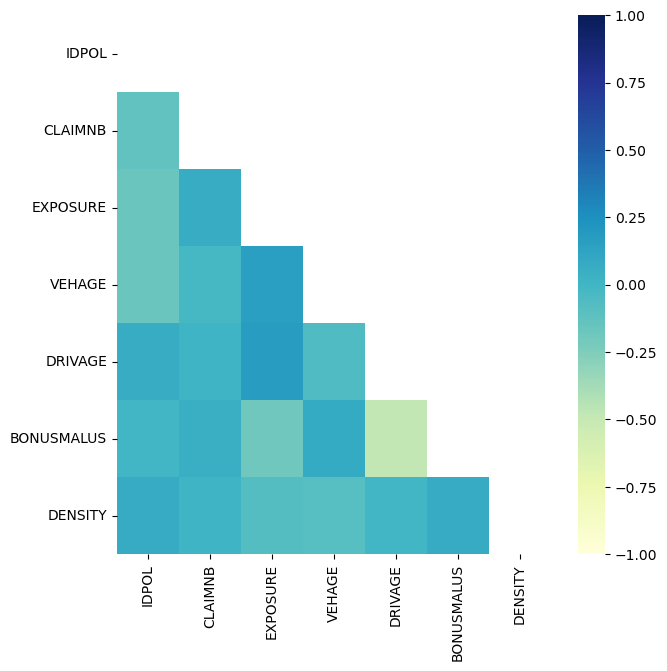

In [23]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_transformed_df, dtype=bool))

# Create a heatmap with the features
plt.figure(figsize=(7, 7))
heatmap = sns.heatmap(corr_transformed_df, mask=mask, cmap="YlGnBu", annot=True, vmin=-1, vmax=1)

In [24]:
insurance_policy_claims_df.describe().sort("SUMMARY").show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"IDPOL"             |"CLAIMNB"           |"EXPOSURE"          |"AREA"  |"VEHPOWER"  |"VEHAGE"           |"DRIVAGE"           |"BONUSMALUS"        |"VEHBRAND"  |"VEHGAS"   |"DENSITY"          |"REGION"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|count      |678013.0            |678013.0            |678013.0            |678013  |678013      |678013.0           |678013.0            |678013.0            |678013      |678013     |678013.0           |678013    |
|max        |6114330.0           |16.0                |2.01                |'F'     |V9          |100.0              |100.0         

Perform EDA to analyze claims and exposure by vehicle age bands and calculate percentage of total exposure and claims per unit exposure.

In [26]:
vehicle_age_banded_df=insurance_policy_claims_df.groupBy("VEHICLE_AGE_BANDED").agg(sum("ClaimNB").alias("vehicle_age_banded_Claims"),\
    sum("Exposure").alias("vehicle_age_banded_Exposure")) \
    .join(insurance_policy_claims_df.groupBy().agg(sum("EXPOSURE").alias("Total_Exposure"))) 

vehicle_age_banded_df  =vehicle_age_banded_df.with_columns(["Percentage_of_total_exposure", "claims_per_unit_exposure"], [(vehicle_age_banded_df["vehicle_age_banded_Exposure"] / vehicle_age_banded_df["Total_Exposure"])\
                                                 ,  (vehicle_age_banded_df["vehicle_age_banded_Claims"]/ vehicle_age_banded_df["vehicle_age_banded_Exposure"] )])

vehicle_age_banded_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"VEHICLE_AGE_BANDED"  |"VEHICLE_AGE_BANDED_CLAIMS"  |"VEHICLE_AGE_BANDED_EXPOSURE"  |"TOTAL_EXPOSURE"    |"PERCENTAGE_OF_TOTAL_EXPOSURE"  |"CLAIMS_PER_UNIT_EXPOSURE"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|VEHAGE_NewVehicle     |5205                         |16719.028728946534             |358499.44546298234  |0.04663613553810335             |0.3113219125575345          |
|VEHAGE_1-4            |7370                         |79548.8475761656               |358499.44546298234  |0.22189392084953613             |0.09264747667077702         |
|VEHAGE_0-1            |2931                         |32749.537618833587             |358499.44546298234  |0.09135171067430622             |0.08949744

In [27]:
# Convert Snowpark DataFrame to Pandas DataFrame
vehicle_age_banded_pd_df = vehicle_age_banded_df.to_pandas()

# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the blue bars for the percentage of total exposure
ax1.bar(vehicle_age_banded_pd_df['VEHICLE_AGE_BANDED'], vehicle_age_banded_pd_df['PERCENTAGE_OF_TOTAL_EXPOSURE'], color='blue', label='% of Total Exposure')
ax1.set_xlabel('Vehicle Age Banded')
ax1.set_ylabel('% of Total Exposure', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the red line plot
ax2 = ax1.twinx()
ax2.plot(vehicle_age_banded_pd_df['VEHICLE_AGE_BANDED'], vehicle_age_banded_pd_df['CLAIMS_PER_UNIT_EXPOSURE'], color='red', marker='o', label='Claim Frequency')
ax2.set_ylabel('Claim Frequency', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title and show the plot
plt.title('Claim Frequency by Vehicle Age')
fig.tight_layout()
plt.show()

The chart displays claim frequency based on grouped vehicle age, revealing higher frequencies for brand new cars (where veh_age == 0).

If we were to consider grouping 0-year-old cars with 1-year-old cars without data insights, it would moderate the substantial difference in claim frequency, diminishing the model's predictive accuracy.


### Data cleaning

Let's remove extra quotation marks


In [29]:
def fix_values(columnn):
    return upper(regexp_replace(columnn, '\'',''))

for col in ["REGION","VEHGAS","VEHBRAND","AREA"]:
    insurance_policy_claims_df = insurance_policy_claims_df.with_column(col, fix_values(col))

insurance_policy_claims_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"IDPOL"  |"CLAIMNB"  |"EXPOSURE"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"DENSITY"  |"DRIVER_AGE_BANDED"  |"VEHICLE_AGE_BANDED"  |"REGION"  |"VEHGAS"  |"VEHBRAND"  |"AREA"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1        |1          |0.1         |V5          |0         |55         |50            |1217       |DRIVAGE_45-55        |VEHAGE_NewVehicle     |R82       |REGULAR   |B12         |D       |
|3        |1          |0.77        |V5          |0         |55         |50            |1217       |DRIVAGE_45-55        |VEHAGE_NewVehicle     |R82       |REGULAR   |B12         |D       |
|5        |1          |0.75        |V6          |2     

## Feature Transformations
We will illustrate a few of the transformation functions here, but the rest can be found in the [documentation](https://docs.snowflake.com/developer-guide/snowpark-ml/snowpark-ml-modeling).

Let's use the `OrdinalEncoder` to transform `VEHPOWER` from categorical to numerical values so they are more meaningful.

In [30]:
# Ordinal encoding
input_categorical_columns_oe=["VEHPOWER"]
output_categorical_columns_oe = ["VEHPOWER_OE"]
categories_to_ordinal_encode = {
    "VEHPOWER": np.array(["V15", "V14", "V13", "V12", "V11", "V10", "V9", "V8", "V7", "V6", "V5", "V4"]),
}
snowml_oe = snowml.OrdinalEncoder(input_cols=input_categorical_columns_oe, output_cols=output_categorical_columns_oe, categories=categories_to_ordinal_encode)
ord_encoded_claims_df = snowml_oe.fit(insurance_policy_claims_df).transform(insurance_policy_claims_df)

# Show the encoding
print(snowml_oe._state_pandas)
print(f"Total number of rows in source df: {ord_encoded_claims_df.count()}")
ord_encoded_claims_df.show()

   _COLUMN_NAME _CATEGORY  _INDEX
0      VEHPOWER       V15       0
1      VEHPOWER       V14       1
2      VEHPOWER       V13       2
3      VEHPOWER       V12       3
4      VEHPOWER       V11       4
5      VEHPOWER       V10       5
6      VEHPOWER        V9       6
7      VEHPOWER        V8       7
8      VEHPOWER        V7       8
9      VEHPOWER        V6       9
10     VEHPOWER        V5      10
11     VEHPOWER        V4      11
Total number of rows in source df: 678013
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"VEHPOWER_OE"  |"IDPOL"  |"CLAIMNB"  |"EXPOSURE"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"DENSITY"  |"DRIVER_AGE_BANDED"  |"VEHICLE_AGE_BANDED"  |"REGION"  |"VEHGAS"  |"VEHBRAND"  |"AREA"  |
----------------------------------------------------------------------------------------------------------

## Feature Engineering

After our feature pipelines are fully setup, we can start using them to generate training data and later do model prediction.

### Access Features from Feature Store

In [ ]:
# Access feature views
fs=FeatureStore(
session=session,
database=f"{solution_prefix}_PROD",
    name="FS",
    default_warehouse=f"{solution_prefix}_DS_WH")

insurance_claims_fv : FeatureView = fs.get_feature_view(
    name='INSURANCE_CLAIMS_FEATURES',
    version='V1'
)
print(insurance_claims_fv)

Generate training data is easy since materialized FeatureViews already carry most of the metadata like join keys, timestamp for point-in-time lookup, etc. We just need to provide the spine data (it's called spine because we are essentially enriching the data by joining features with it). We can also generate dataset with a subset of features in the feature view by `slice`.

In [36]:
spine_df = ord_encoded_claims_df.select("IDPOL","VEHPOWER_OE")

my_claims_dataset = fs.generate_dataset(
    name="my_claims_training_dataset",
    spine_df=spine_df, 
    features=[insurance_claims_fv],
    spine_timestamp_col=None, 
    spine_label_cols=["CLAIMNB"],
    exclude_columns=['IDPOL'],
    desc="my training dataset with EXTRA_CLAIMS_FEATURES",
)

Convert dataset to a snowpark dataframe and examine all the features in it.

In [ ]:
training_data_df = my_claims_dataset.read.to_snowpark_dataframe()
training_data_df

In [37]:
training_data_df = my_claims_dataset.read.to_snowpark_dataframe()
assert training_data_df.count() == insurance_policy_claims_df.count()
training_data_df=training_data_df.drop("DENSITY")

training_data_df.show()
training_data_df.write.mode("overwrite").save_as_table("analytics.claims_for_modeling")

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"VEHPOWER_OE"  |"CLAIMNB"  |"EXPOSURE"           |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"DRIVER_AGE_BANDED"  |"VEHICLE_AGE_BANDED"  |"REGION"  |"VEHGAS"  |"VEHBRAND"  |"AREA"  |"FS_LOG_DENSITY"    |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|11.0           |0          |1.0                  |V4          |10        |68         |57            |DRIVAGE_55-70        |VEHAGE_4-10           |R24       |REGULAR   |B2          |D       |6.752270221710205   |
|10.0           |0          |0.23999999463558197  |V5          |14        |38         |50            |DRIVAGE_35-45        |VEHAGE_Over_10,       |R

Let's use the `OneHotEncoder` to transform the categorical columns to numerical columns.


In [38]:
# One hot encoding
input_categorical_columns_ohe=["VEHPOWER", "DRIVER_AGE_BANDED", "VEHICLE_AGE_BANDED","VEHBRAND","VEHGAS","REGION"]
output_categorical_columns_ohe = ["VEHPOWER_OHE", "DRIVER_AGE_BANDED_OHE", "VEHICLE_AGE_BANDED_OHE","VEHBRAND_OHE","VEHGAS_OHE","REGION_OHE"]

snowml_ohe = snowml.OneHotEncoder(input_cols=input_categorical_columns_ohe,\
     output_cols=output_categorical_columns_ohe)
ohencoded_claims_df = snowml_ohe.fit(ord_encoded_claims_df).transform(ord_encoded_claims_df)

np.array(ohencoded_claims_df.columns)

array(['VEHPOWER_OHE_V10', 'VEHPOWER_OHE_V11', 'VEHPOWER_OHE_V12',
       'VEHPOWER_OHE_V13', 'VEHPOWER_OHE_V14', 'VEHPOWER_OHE_V15',
       'VEHPOWER_OHE_V4', 'VEHPOWER_OHE_V5', 'VEHPOWER_OHE_V6',
       'VEHPOWER_OHE_V7', 'VEHPOWER_OHE_V8', 'VEHPOWER_OHE_V9',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_18-21"',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_21-25"',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_25-35"',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_35-45"',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_45-55"',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_55-70"',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_Over_70,"',
       '"VEHICLE_AGE_BANDED_OHE_VEHAGE_0-1"',
       '"VEHICLE_AGE_BANDED_OHE_VEHAGE_1-4"',
       '"VEHICLE_AGE_BANDED_OHE_VEHAGE_4-10"',
       '"VEHICLE_AGE_BANDED_OHE_VEHAGE_NewVehicle"',
       '"VEHICLE_AGE_BANDED_OHE_VEHAGE_Over_10,"', 'VEHBRAND_OHE_B1',
       'VEHBRAND_OHE_B10', 'VEHBRAND_OHE_B11', 'VEHBRAND_OHE_B12',
       'VEHBRAND_OHE_B13', 'VEHBRAND_OHE_B14', 'VEHBRAND_OHE_B2',
    

Let's use the `KBIN` to transform the categorical columns to numerical columns.



In [39]:
# kbin
# Let's put this into discrete bins and then encode them as ordinals.
input_categorical_columns_kbin=["BONUSMALUS"]
output_categorical_columns_kbin = ["BONUSMALUS_BINNED"]

snowml_kbins = snowml.KBinsDiscretizer(input_cols=input_categorical_columns_kbin, output_cols=output_categorical_columns_kbin, encode = 'ordinal', n_bins = 10)

kbins_transformed_claims_frequency_df = snowml_kbins.fit(ohencoded_claims_df).transform(ohencoded_claims_df)

kbins_transformed_claims_frequency_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Finally, we can also build out a full preprocessing `Pipeline`.

This will be useful for both the ML training & inference steps to have standarized feature transformations.

In [40]:
# Build the pipeline
preprocessing_pipeline = Pipeline(
    steps=[
            (
                "OE",
                snowml.OrdinalEncoder(input_cols=input_categorical_columns_oe, output_cols=output_categorical_columns_oe, categories=categories_to_ordinal_encode,)
            ),
            (
                "OHE",
                snowml.OneHotEncoder(input_cols=input_categorical_columns_ohe,output_cols=output_categorical_columns_ohe)
            ),
            (
                "KBINS",
                snowml.KBinsDiscretizer(input_cols=input_categorical_columns_kbin, output_cols=output_categorical_columns_kbin, encode = 'ordinal', n_bins = 10)
            )

    ]
)

PIPELINE_FILE = 'preprocessing_pipeline.joblib'
joblib.dump(preprocessing_pipeline, PIPELINE_FILE) # We are just pickling it locally first

transformed_df = preprocessing_pipeline.fit(training_data_df).transform(training_data_df)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [41]:
# You can also save the pickled object into the stage
session.file.put(PIPELINE_FILE, "@ANALYTICS.NOTEBOOK", overwrite=True)

[PutResult(source='preprocessing_pipeline.joblib', target='preprocessing_pipeline.joblib.gz', source_size=2098, target_size=1152, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

## Model Training

### ML Modeling
In this section, we will illustrate how to train an XGBoost model with the claims dataset using the Snowpark ML Model API.

The Snowpark ML Model API currently supports sklearn, xgboost, and lightgbm models.

In [42]:
# Categorize all the features for modeling
CATEGORICAL_COLUMNS = [ "DRIVER_AGE_BANDED", "VEHICLE_AGE_BANDED","VEHBRAND","VEHGAS","REGION"]
CATEGORICAL_COLUMNS_OE = ["VEHPOWER_OE"] # To name the ordinal encoded columns
NUMERICAL_COLUMNS = ["EXPOSURE", "FS_LOG_DENSITY", "BONUSMALUS","VEHAGE","DRIVAGE"]

LABEL_COLUMNS = ['CLAIMNB']
OUTPUT_COLUMNS = ['PREDICTED_CLAIMNB']

### Build a simple XGBoost Regression model
What's happening here?

* The model.fit() function actually creates a temporary stored procedure in the background. This also means that the model training is a single-node operation. Be sure to use a Snowpark Optimized Warehouse if you need more memory. We are just using an XS Standard Virtual Warehouse here, which we created at the beginning of this quickstart.
* The model.predict() function actualls creates a temporary vectorized UDF in the background, which means the input DataFrame is batched as Pandas DataFrames and inference is parallelized across the batches of data.
You can check the query history once you execute the following cell to check.

In [44]:
# Split the data into train and test sets
claims_frequency_train_df, claims_frequency_test_df = training_data_df.random_split(weights=[0.9, 0.1], seed=0)

# Run the train and test sets through the Pipeline object we defined earlier
train_df = preprocessing_pipeline.fit(claims_frequency_train_df).transform(claims_frequency_train_df)
test_df = preprocessing_pipeline.transform(claims_frequency_test_df)
train_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[Predict Option1] We can predict using the model and the feature engineered values. Does not use the Feature Store


In [45]:
# Define the XGBRegressor
regressor = XGBRegressor(
   input_cols=NUMERICAL_COLUMNS+CATEGORICAL_COLUMNS_OE,
#    input_cols=filtered_list,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

# Train
regressor.fit(train_df)

# Predict
result = regressor.predict(test_df)
result.show()
df_selected = result.withColumn('PREDICTED_RESULT', result["PREDICTED_CLAIMNB"])
df_selected.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [218]:
# Just to illustrate, we can also pass in a Pandas DataFrame to Snowpark ML's model.predict()
regressor.predict(test_df[CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS].to_pandas())

,VEHPOWER_OE,EXPOSURE,FS_LOG_DENSITY,BONUSMALUS,VEHAGE,DRIVAGE,PREDICTED_CLAIMNB
0,7.0,0.050000,8.173293,54,0,50,0.026461
1,10.0,0.070000,5.087596,50,0,52,0.147435
2,8.0,0.020000,6.873164,50,0,54,0.065131
3,10.0,0.090000,5.153292,50,0,35,0.151103
4,11.0,0.090000,2.708050,76,0,29,0.104061
...,...,...,...,...,...,...,...
68049,4.0,0.060000,6.894670,50,2,60,0.018099
68050,6.0,0.040000,2.944439,50,3,32,0.015693
68051,7.0,0.040000,5.834811,50,2,66,-0.002000
68052,7.0,0.008219,4.094345,50,3,31,-0.004530


[Predict Option2] Now we can predict using the model and the feature values retrieved from feature
store.

In [46]:
claims_test_df = spine_df.limit(5).select("IDPOL","VEHPOWER_OE")

# load back feature views from dataset
fvs = fs.load_feature_views_from_dataset(my_claims_dataset)
enriched_df = fs.retrieve_feature_values(claims_test_df, fvs)
enriched_df = enriched_df.drop('IDPOL')
enriched_df.show()
pred = regressor.predict(enriched_df.to_pandas())
print(pred)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"VEHPOWER_OE"  |"CLAIMNB"  |"EXPOSURE"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"DENSITY"  |"DRIVER_AGE_BANDED"  |"VEHICLE_AGE_BANDED"  |"REGION"  |"VEHGAS"  |"VEHBRAND"  |"AREA"  |"FS_LOG_DENSITY"    |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|9.0            |1          |0.75        |V6          |2         |52         |50            |54         |DRIVAGE_45-55        |VEHAGE_1-4            |R22       |DIESEL    |B12         |B       |3.9889840465642745  |
|10.0           |1          |0.1         |V5          |0         |55         |50            |1217       |DRIVAGE_45-55        |VEHAGE_Ne

Let's analyze the results using Snowpark ML's MSE model metric.

In [47]:
from snowflake.ml.modeling.metrics import mean_squared_error

mse = mean_squared_error(df=df_selected, 
                                        y_true_col_names="CLAIMNB", 
                                        y_pred_col_names="PREDICTED_RESULT")

df_selected.select("CLAIMNB", "PREDICTED_RESULT").show()
print(f"Mean squared error: {mse}")

----------------------------------
|"CLAIMNB"  |"PREDICTED_RESULT"  |
----------------------------------
|0          |0.0                 |
|0          |0.0                 |
|0          |0.0                 |
|0          |0.0                 |
|0          |0.0                 |
|0          |0.0                 |
|0          |0.0                 |
|0          |0.0                 |
|2          |0.0                 |
|0          |0.0                 |
----------------------------------

Mean squared error: 0.06030373245568724


Now, let's use Snowpark ML's Distributed GridSearchCV() function to find optimal model parameters.

We will increase the warehouse size to scale up our hyperparameter tuning to take advantage of parallelized model training to accelerate this search.

In [ ]:
ALTER WAREHOUSE "{{solution_prefix}}_DS_WH" SET WAREHOUSE_SIZE="XLARGE";

In [49]:
grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators":[100, 200, 300, 400, 500],
        "learning_rate":[0.1, 0.2, 0.3, 0.4, 0.5],
    },
    n_jobs = -1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols=CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

# Train
grid_search.fit(train_df)

In [ ]:
ALTER WAREHOUSE "{{solution_prefix}}_DS_WH" SET WAREHOUSE_SIZE="XSMALL";

We see that the best estimator has the following parameters: n_estimators=100 & learning_rate=0.1.

We can use to_sklearn() in order to get the actual xgboost model object, which gives us access to all its attributes.

In [51]:
grid_search.to_sklearn().best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

We can also analyze the grid search results.

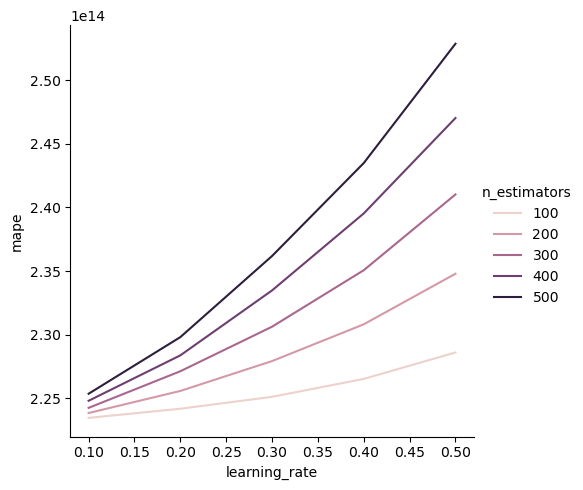

In [52]:
# Analyze grid search results
gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])

# Extracting the mean test score (MAPE)
mape_val = gs_results["mean_test_score"] * -1

# Create a DataFrame to organize the results
gs_results_df = pd.DataFrame(data={
    "n_estimators": n_estimators_val,
    "learning_rate": learning_rate_val,
    "mape": mape_val
})

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot MAPE vs Learning Rate, with different lines for each n_estimators
for n_estimators in gs_results_df['n_estimators'].unique():
    subset = gs_results_df[gs_results_df['n_estimators'] == n_estimators]
    plt.plot(subset['learning_rate'], subset['mape'], label=f'n_estimators = {n_estimators}', marker='o')

# Adding labels and title
plt.xlabel('Learning Rate')
plt.ylabel('Mean Absolute Percentage Error (MAPE)')
plt.title('Grid Search Results: MAPE vs Learning Rate')

# Show legend
plt.legend(title="Number of Estimators")

# Show the plot
plt.show()

This is consistent with the learning_rate=0.1 and n_estimator=100 chosen as the best estimator with the lowest MAPE.

Now, let's predict and analyze the results from using the best estimator.

In [53]:
# Predict
result = grid_search.predict(test_df)

# Analyze results
mse = mean_squared_error(df=result,
                         y_true_col_names="CLAIMNB",
                         y_pred_col_names="PREDICTED_CLAIMNB")

result.select("CLAIMNB", "PREDICTED_CLAIMNB").show()
print(f"Mean squared error: {mse}")

------------------------------------
|"CLAIMNB"  |"PREDICTED_CLAIMNB"   |
------------------------------------
|0          |0.04103938490152359   |
|0          |0.09475480765104294   |
|0          |0.019450537860393524  |
|0          |0.07084453105926514   |
|0          |0.03202999755740166   |
|0          |0.04335125908255577   |
|0          |0.028002101927995682  |
|0          |0.032839346677064896  |
|2          |0.06711512058973312   |
|0          |0.009918758645653725  |
------------------------------------

Mean squared error: 0.05521252527279323


In [54]:
optimal_model = grid_search.to_sklearn().best_estimator_
optimal_n_estimators = grid_search.to_sklearn().best_estimator_.n_estimators
optimal_learning_rate = grid_search.to_sklearn().best_estimator_.learning_rate

optimal_mse = gs_results_df.loc[(gs_results_df['n_estimators']==optimal_n_estimators) &
                                 (gs_results_df['learning_rate']==optimal_learning_rate), 'mape'].values[0]

## Model Deployment
The model will be logged to the Snowflake Model Registry. The logged model will then be deployed for inference on Snowpark Container Services (SPCS).

In [ ]:
# Get sample input data to pass into the registry logging function
X = train_df.select(CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS).limit(100)

# Define model name
model_name = "CLAIMS_PREDICTION"

# Create a registry and log the model
registry = Registry(session=session, database_name=f"{solution_prefix}_PROD", schema_name="REGISTRY")

# Let's first log the very first model we trained
model_ver = registry.log_model(
    model_name=model_name,
    version_name='V1',
    model=regressor,
    sample_input_data=X, # to provide the feature schema
)

# Add evaluation metric
model_ver.set_metric(metric_name="Mean squared error", value=mse)

In [ ]:
# Add a description
model_ver.comment = "This is the second iteration of our Claims Prediction model. "

# Now, let's log the optimal model from GridSearchCV
model_ver2 = registry.log_model(
    model_name=model_name,
    version_name='V2',
    model=optimal_model,
    sample_input_data=X, # to provide the feature schema
)

# Add evaluation metric
model_ver2.set_metric(metric_name="Mean squared error", value=optimal_mse)

# Add a description
model_ver2.comment = "This is the second iteration of our Claims Prediction model \
                        where we performed hyperparameter optimization."

## Model Inference
Inference of the test data will be completed using the model deployed to SPCS running on a dedicated compute pool. Features for the test data will be accessed from the feature store and the preprocessing pipeline will transform the data as required.

In [ ]:
# Get features from feature store
test_df = fs.retrieve_feature_values(
    spine_df=claims_test_df,
features=[insurance_claims_fv]
)
#test_df_subset = test_df.sample(100000)
test_df_subset = test_df.sample(n=10000)

# Preprocess
test_data = preprocessing_pipeline.transform(test_df_subset)

# To maintain the Order
test_data_pd = test_data.to_pandas()

predictions = model_ver2.run(test_data_pd, function_name="predict")

predictions['output_feature_0'] = predictions['output_feature_0'].apply(
    lambda x: x[0] if isinstance(x, list) else float(x)
)
eval_df_pd = pd.concat([test_data_pd, 
                       predictions.rename(columns={'output_feature_0': 'PREDICTION'})], axis=1)
eval_df = session.create_dataframe(eval_df_pd)
eval_df.show()